In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from skorch.regressor import NeuralNetRegressor
from tabularasa.MixedNet import MixedNet

In [53]:
df = pd.read_pickle('./examples/data/simple_train.pkl')

In [54]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb1 = nn.Embedding(50, 16)
        self.fc1 = nn.Linear(1 + 16, 16)
    
    def forward(self, X_non_monotonic):
        X = torch.cat([X_non_monotonic[:, 1, None].float(), 
                       self.emb1(X_non_monotonic[:, 0, None].long()).squeeze()], 1)
        return F.relu(self.fc1(X))

In [55]:
model = NeuralNetRegressor(MixedNet,
                           max_epochs=25,
                           lr=0.001,
                           optimizer=torch.optim.Adam,
                           module__non_monotonic_net=EmbeddingNet(),
                           module__dim_non_monotonic=16,
                           module__dim_monotonic=2,
                           module__layers=[128, 128, 32],
                           module__integration_steps=300)

In [56]:
model.fit({'X_monotonic': df[['x1', 'x2']].values,
           'X_non_monotonic': df[['x3', 'x4']].values},
          df[['y']].values)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5813        0.4044  8.8346
      2        0.3292        0.3058  9.4620
      3        0.3174        0.2991  9.0462
      4        0.2975        0.2969  8.8295
      5        0.2953        0.2956  8.5134
      6        0.2921        0.2929  8.5057
      7        0.2897        0.2908  8.4150
      8        0.2863        0.2874  8.5299
      9        0.2820        0.2829  8.4708
     10        0.2752        0.2748  8.5166
     11        0.2641        0.2615  8.6080
     12        0.2494        0.2453  8.5891
     13        0.2313        0.2236  8.6867
     14        0.2072        0.1993  8.5916
     15        0.1791        0.1756  8.4915
     16        0.1531        0.1581  8.6544
     17        0.1305        0.1492  8.7560
     18        0.1163        0.1511  8.4283
     19        0.1162        0.1317  8.5691
     20        0.1249        0.1896  8.5640
     21        0.1977        0.2

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MixedNet(
    (non_monotonic_net): EmbeddingNet(
      (emb1): Embedding(50, 16)
      (fc1): Linear(in_features=17, out_features=16, bias=True)
    )
    (umnn): SlowDMonotonicNN(
      (outer_net): MonotonicNN(
        (integrand): IntegrandNN(
          (net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
            (5): ReLU()
            (6): Linear(in_features=32, out_features=1, bias=True)
            (7): ELU(alpha=1.0)
          )
        )
        (net): Sequential(
          (0): Linear(in_features=16, out_features=128, bias=True)
          (1): ReLU()
          (2): Linear(in_features=128, out_features=128, bias=True)
          (3): ReLU()
          (4): Linear(in_features=128, out_feat

In [57]:
quantiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

In [59]:
results = []
for q in np.quantile(df['x1'], quantiles):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = model.predict({'X_monotonic': dfc[['x1', 'x2']].values,
                       'X_non_monotonic': dfc[['x3', 'x4']].values})
    p = pd.DataFrame(pd.Series(p[:, 0]).describe(percentiles=quantiles)).T
    p['x1'] = q
    results.append(p)
results = pd.concat(results, axis=0)

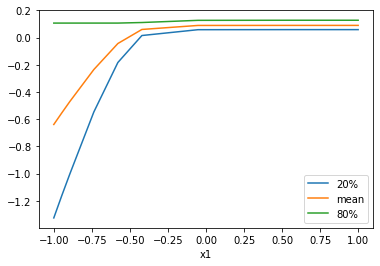

In [60]:
results.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()